In [1]:
import math
import numpy as np
import torch
from load_data import load_data
from model import ElectronOpticsPredictor, optimize_voltages

In [8]:
solid_angle_scaling = math.sin(math.radians(5 / 2)) / math.sin(math.radians(60 / 2))
APER_0_D = 0.5
DET_D = 25


def angle_resolved_aper0(aper0_map: np.ndarray) -> np.ndarray:
    aberrations = (
        aper0_map[:, 0] ** 2
        + aper0_map[:, 2] ** 2
        + (aper0_map[:, 3] * solid_angle_scaling) ** 2
        + (aper0_map[:, 4] * (solid_angle_scaling**2)) ** 2
        + (aper0_map[:, 5] * (solid_angle_scaling**3)) ** 2
    )
    return (
        aberrations
        + (np.abs(aper0_map[:, 1] * solid_angle_scaling) - APER_0_D / 2) ** 2
    )


def spatial_resolved_detector(detector_map: np.ndarray) -> np.ndarray:
    aberrations = (
        (detector_map[:, 1] * solid_angle_scaling) ** 2
        + detector_map[:, 2] ** 2
        + (detector_map[:, 3] * solid_angle_scaling) ** 2
        + (detector_map[:, 4] * (solid_angle_scaling**2)) ** 2
        + (detector_map[:, 5] * (solid_angle_scaling**3)) ** 2
    )
    return aberrations + (np.abs(detector_map[:, 0]) - DET_D / 2) ** 2


def metric(output: np.ndarray) -> np.ndarray:
    if isinstance(output, torch.Tensor):
        return objective(output)
    return angle_resolved_aper0(output[:, :6]) * 1000 + spatial_resolved_detector(
        output[:, 6:]
    )


def objective(output: torch.Tensor, device: torch.device = None):
    device = torch.device("cpu") if device is None else device
    output.to(device)

    angle_scaling = 1000

    angle_aberrations = (
        output[0] ** 2
        + output[2] ** 2
        + (output[3] * solid_angle_scaling) ** 2
        + (output[4] * (solid_angle_scaling**2)) ** 2
        + (output[5] * (solid_angle_scaling**3)) ** 2
    )
    spatial_aberrations = (
        (output[1 + 6] * solid_angle_scaling) ** 2
        + output[2 + 6] ** 2
        + (output[3 + 6] * solid_angle_scaling) ** 2
        + (output[4 + 6] * (solid_angle_scaling**2)) ** 2
        + (output[5 + 6] * (solid_angle_scaling**3)) ** 2
    )
    return (
        (torch.abs(output[1]) * solid_angle_scaling - APER_0_D / 2) ** 2 * angle_scaling
        + (torch.abs(output[6]) - DET_D / 2) ** 2
        + angle_aberrations * angle_scaling
        + spatial_aberrations
    )

In [3]:
raw_voltages, raw_outputs = load_data("parallel_test_model_data.csv")

In [ ]:
from matplotlib import pyplot as plt
import random

raw_metrics = metric(raw_outputs)
n_bins = 7
max_metric = 600
bin_edges = np.linspace(raw_metrics.min(), max_metric, n_bins)
indices = np.digitize(raw_metrics, bin_edges)

voltages_list: list = raw_voltages.tolist()
outputs_list: list = raw_outputs.tolist()
voltages = []
outputs = []
bin_empty = False
while not bin_empty:
    for i in range(1, n_bins + 1):
        matches = np.where(indices == i)[0]
        if matches.size == 0:
            bin_empty = True
        else:
            random_match = random.choice(matches)

            indices = np.delete(indices, random_match)
            voltages.append(voltages_list.pop(random_match))
            outputs.append(outputs_list.pop(random_match))

voltages = np.array(voltages)
outputs = np.array(outputs)

IndexError: Cannot choose from an empty sequence

Using device: cpu
Epoch 0: Train Loss = 0.386314, Val Loss = 0.044400
Training completed. Best validation loss: 0.000435


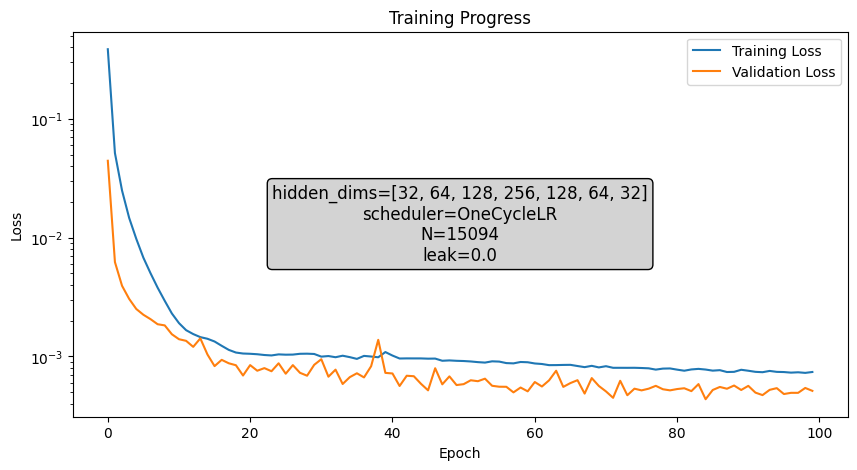

In [ ]:
predictor = ElectronOpticsPredictor(
    input_dim=raw_voltages.shape[1], output_dim=raw_outputs.shape[1]
)
predictor.train(raw_voltages, raw_outputs, epochs=100)

In [20]:
predictor.save_model("test_pred")

In [4]:
predictor = ElectronOpticsPredictor.load_model("test_pred")

Using device: cpu


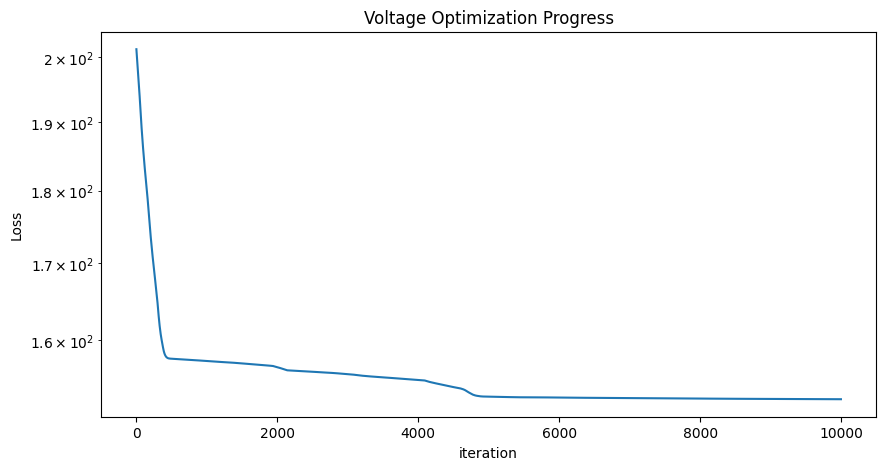

(array([ 62.392895 ,  68.86209  , 312.29898  , 338.69034  , 824.4149   ,
        -80.08272  , 351.5503   ,  -1.0582737, 204.3204   , 434.99744  ,
        236.48624  , 544.5795   , 582.76636  , 128.70305  ], dtype=float32),
 tensor([ 1.5619e-02,  2.7685e+00, -8.7500e-05, -5.9509e-04,  6.5430e-02,
          7.5830e-01, -1.7838e-01, -3.2788e+00, -5.3528e-02, -5.5361e+00,
         -4.9922e+01, -5.3944e+02]),
 152.7292022705078)

In [11]:
predictor.optimize_voltages(metric, n_iterations=10000, random_restarts=1)